# "Drop Number One" analysis

This is a modification of the "Drop One Variable" analysis that drops the top-ranked observation(s) instead of the series of input variables. This analysis tests the leverage of the "most vulnerable" observation on the net contributions of input variables to SoVI as well as the changes in index rank among US counties. If the index is robust to the leverage of individual observations, we expect to see minimal reshuffling of variable influence/county ranks when the top-ranked observation is dropped.

In [1]:
import os
import pandas as pd
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.mstats import zscore as ZSCORE
from scipy.stats import rankdata
from scipy.stats import spearmanr 

# sovi compute script
import sys
sys.path.append(os.path.join(os.getcwd(),'code'))
from spss_pca import SPSS_PCA
import compute_sovis

C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Joe\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


did not pull supplementary ACS data - A


C:\Users\Joe\Anaconda3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 7 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Users\Joe\Anaconda3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: g02016, g15001, g15003, g15007, g25019, g36085, g53055
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 'g02016', ' is an island (no neighbors)')
('WARNING: ', 'g15001', ' is an island (no neighbors)')
('WARNING: ', 'g15003', ' is an island (no neighbors)')
('WARNING: ', 'g15007', ' is an island (no neighbors)')
('WARNING: ', 'g25019', ' is an island (no neighbors)')
('WARNING: ', 'g36085', ' is an island (no neighbors)')
('WARNING: ', 'g53055', ' is an island (no neighbors)')


## Methods

#### Some prep: 

In [2]:
#Get attribute names
attr_names=[j[0] for j in compute_sovis.input_names]

(Some of the stuff in the cell below might be removable. I just kept it all for now to make sure everything was in place for running SoVI...)

In [3]:
# rather than populating the `netContrib` object
# we can just use the final var contributions from 
# `compute_sovis`...
netContrib=compute_sovis.variable_contributions

#reorder table        
cols = ['USA', 'FEMA_1', 'g23g33g25', 
'FEMA_2', 'g36','FEMA_3', 'g51', 'FEMA_4', 'g13', 'FEMA_5', 'g17',
'FEMA_6', 'g48', 'FEMA_7', 'g29', 'FEMA_8', 'g46', 'FEMA_9', 'g06', 'FEMA_10', 
'g16']
netContrib = netContrib[cols]

#variable rank using absolute value      
rankContrib = abs(netContrib).apply(rankdata, axis=0, method='average')
rankContrib = (28-rankContrib) + 1

combContrib = pd.DataFrame(columns=list(netContrib.columns), index=list(netContrib.index))
#can't think of a more elegant way to do this
for aRow in range(netContrib.shape[1]):
    for aCol in range(netContrib.shape[0]):
        combContrib.ix[aCol][aRow] = str(round(netContrib.ix[aCol][aRow], 2)) + ' (' + str(int(rankContrib.ix[aCol][aRow])) + ')'

#build list of varIDs and human readable names
#sort and use as index for conContrib
nameSort = [[name, hrname] for name, sign, sample, hrname in compute_sovis.input_names]
nameSort = pd.DataFrame(nameSort)
nameSort.index = nameSort.loc[:,0]
nameSort = nameSort.reindex(list(combContrib.index))    
    
#set descriptive names
combContrib.index = list(nameSort.loc[:,1])

# # write out results
# combContrib

I found an issue with the computed SoVI ranks. The SoVI score (`sovi`) is added to `compute_sovis.US_Sovi_Score` as a generic "object" which messes up the ranking. Therefore it is necessary to re-rank SoVI:

In [4]:
## convert sovi score to float
# compute_sovis.US_Sovi_Score.sovi=compute_sovis.US_Sovi_Score.sovi.astype('float64')

In [5]:
## re-rank sovi
# compute_sovis.US_Sovi_Score['rank']=compute_sovis.US_Sovi_Score.sovi.rank(ascending=False)

Confirm that re-ranking worked, using previous results from 2014. Now there should be no difference in ranks following the conversion of the new run's SoVI to `float64`:

In [6]:
# sovi_old=pd.read_csv('data/check/SoVI_USA_all.csv')
# sovi_old['rank']=sovi_old.sovi.rank(ascending=False)

# sovi_orig=compute_sovis.US_Sovi_Score.copy()
# sovi_orig['Geo_FIPS']=sovi_orig.index
# sovi_compare=pd.merge(sovi_old,sovi_orig,on='Geo_FIPS')

# (sovi_compare.rank_x-sovi_compare.rank_y).describe()

Get the index of the "most vulnerable" county in the USA according to SoVI (Bronx, NY), and generate a version of the SoVI inputs with it dropped:

In [7]:
# get the index of the 
# "most vulnerable" county in USA
sovi_no1=compute_sovis.US_Sovi_Score[compute_sovis.US_Sovi_Score['rank']==compute_sovis.US_Sovi_Score['rank'].min()].index

In [8]:
# the data without Bronx
US_drop_no1=compute_sovis.US_All.drop(sovi_no1)

Preserve the original net contribution and county ranks. These will be used to compute changes in net contribution/county rank once SoVI is recomputed:

In [9]:
# These are still needed for computing change in rank...

#Construct table to hold the results of the drop one analysis
#Sort variable list based on importance rank.
USvarRanks = rankContrib.USA.copy() #have to make a copy to sort index
USvarRanks.sort('USA')
# dropLevels = USvarRanks.index

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [10]:
# preserve the original county ranks
# also for computing change in rank...
orig_rank=compute_sovis.US_Sovi_Score.drop(sovi_no1)['rank']

#### Now let's recompute SoVI with Bronx, NY dropped:

In [11]:
# preserve GEOIDs as an index
# for computed SoVI
geoLevels=US_drop_no1.Geo_FIPS

#Compute drop "number one"
pca = SPSS_PCA(US_drop_no1.drop(['Geo_FIPS', 'stateID'], axis = 1, inplace = False), reduce=True, varimax=True)
sovi_actual = pca.scores_rot.sum(1)
sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
US_SoVI_Drop1_Score = sovi_actual.values # SoVI score

In [12]:
# add SoVI ranks for run
# any way to clean this up?
US_SoVI_Drop1_Rank = pd.Series([i[0] for i in sovi_actual.values],index=geoLevels).rank(ascending=False)

In [13]:
# check indices match
sum(US_SoVI_Drop1_Rank.index==orig_rank.index)

3142

Recompute net variable contribution:

In [14]:
attrib_contribution = pd.Series(data=pca.weights_rot.sum(1), index=US_drop_no1.columns.drop(['Geo_FIPS', 'stateID']))
#print(j +" " + str(np.isnan(attrib_contribution.values).sum()))
attrib_contribution = attrib_contribution.transpose()

# attrib_contribution.index = [j]
#print(attrib_contribution.loc[j,:])
US_Drop1_NetContrib = attrib_contribution #.values
US_Drop1_NetContrib=US_Drop1_NetContrib.rank(ascending=False)
US_Drop1_NetContrib=US_Drop1_NetContrib.convert_objects(convert_numeric=True)
US_Drop1_NetContrib = US_Drop1_NetContrib.apply(lambda x: np.round(x, 2))

US_Drop1_NetContrib=US_Drop1_NetContrib[USvarRanks.index] # sort values by original index ranking

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### Results

#### Net Contribution
Lots of small movements, and some larger ones for Percent African-American (`QBLACK_ACS`) and Percent of Housing in Mobile Homes (`QMOHO`), whose values drop considerably (-11 and -18, respectively).

In [15]:
nc_chg_dropno1=pd.DataFrame({'orig_rank':USvarRanks,'dropno1_rank':US_Drop1_NetContrib})
nc_chg_dropno1['rank_chg']=nc_chg_dropno1.orig_rank-nc_chg_dropno1.dropno1_rank
nc_chg_dropno1

,dropno1_rank,orig_rank,rank_chg
QAGEDEP_ACS,1.0,1.0,0.0
QFEMALE_ACS,2.0,2.0,0.0
QSERV_ALT,3.0,3.0,0.0
QHISP_ACS,4.0,4.0,0.0
QFEMLBR,5.0,5.0,0.0
QNATAM_ACS,6.0,6.0,0.0
QESL_ALT,7.0,7.0,0.0
QSSBEN,8.0,8.0,0.0
QNOAUTO_ALT,9.0,9.0,0.0
QMOHO,28.0,10.0,-18.0


#### County Rank Change
County ranks appear fairly stable when Bronx, NY is left out of the data. The histogram is centered on near-zero movement, with some left skew (some counties dropping upwards of 150 places).

In [16]:
obs_rchg_drop1=pd.DataFrame({'orig_rank':orig_rank,'dropno1_rank':US_SoVI_Drop1_Rank},index=orig_rank.index)
obs_rchg_drop1['rank_chg']=obs_rchg_drop1.orig_rank-obs_rchg_drop1.dropno1_rank

C:\Users\Joe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


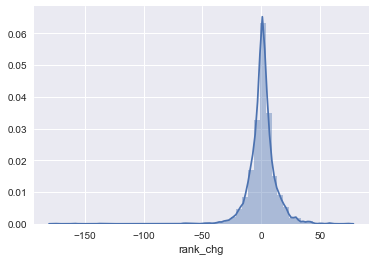

In [17]:
sns.distplot(obs_rchg_drop1.rank_chg)

### Map of Rank Changes
Just a simple `GeoPandas` choropleth to start...

In [18]:
import geopandas as gpd
from matplotlib.pylab import rcParams
import pysal as ps
rcParams['figure.figsize'] = 18, 15

In [19]:
sovi_map=gpd.read_file('data/spatial/USA_Counties_500k.shp')

In [20]:
# remove alaska and hawaii
sovi_map=sovi_map[~sovi_map['geoFIPS'].str.contains('g02') & ~sovi_map['geoFIPS'].str.contains('g15')]

In [21]:
# join the rank changes
obs_rchg_drop1['geoFIPS']=obs_rchg_drop1.index
sovi_map=pd.merge(sovi_map,obs_rchg_drop1,on='geoFIPS')

It is necessary before mapping to convert `rank_chg` to integer so that negative movements plot.

In [22]:
sovi_map.rank_chg=sovi_map.rank_chg.astype('int')

Raw value breaks are not being plotted in order for `geoPandas`, bin the breaks instead to ensure correct plot order:

In [23]:
# generate breaks
bb=ps.Natural_Breaks(sovi_map.rank_chg,k=3)
breaks_unique=np.unique(bb.yb) # unique break levels

In [24]:
## some helper functions for mapping

def getLabels(inData,var,breaks,cl,inc=1):
    
    if cl==breaks.min(): # first entry
        return 'l'+str(cl)+' '+str(inData[var].ix[np.where(breaks==cl)].min())+" : "+str(inData[var].ix[np.where(breaks==cl)].max()) 
    else:
        return 'l'+str(cl)+' '+str(inData[var].ix[np.where(breaks==cl-1)].max()+inc)+" : "+str(inData[var].ix[np.where(breaks==cl)].max()) 


def mapLabels(inData,var,breaks,inc=1,lab=None):

    breaks_unique=np.unique(breaks)
    
    if lab==None: # no custom labelling scheme set
        
        lab=[getLabels(inData,var,breaks,cl,inc) for cl in breaks_unique]
    
    # lookup table for class labels
    lab_lookup=pd.DataFrame({'break_class':breaks_unique,'label':lab})
    
    # the full set of labels
    lab_obs=[lab_lookup[lab_lookup['break_class']==i]['label'][i] for i in breaks]
    
    return lab_obs

Now plot using the binned labels...

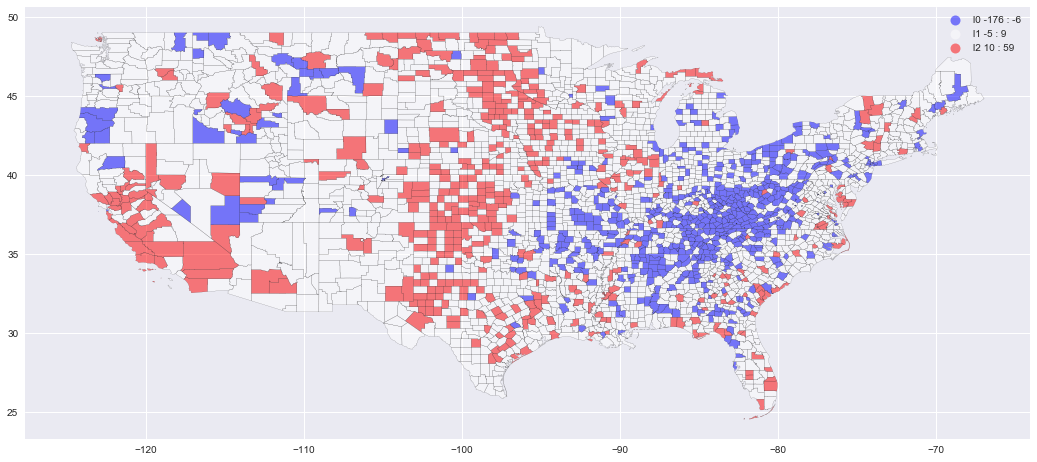

In [25]:
sovi_map['label']=mapLabels(sovi_map,'rank_chg',bb.yb)
sovi_map.plot(column='label',cmap='bwr',linewidth=0.1,legend=True)

When Bronx, NY is dropped, many counties around Ohio appear to drop in SoVI rank, upwards of 176 places. Additionally, counties throughout the Midwest, Texas, and California increase in SoVI rank, upwards of 59 places. While the magnitude of these effects is not great, it is somewhat troubling that the removal of a single county has the potential to affect the rankings of a number of distal counties.

## Automate "Drop Number One"

In [50]:
## "Drop number one" as a function
# one option for sovi, another for netContrib (needs add!)

def dropNo1(inputs,scores,subset=None,netContrib=None,return_no1=False):
    
    """
    inputs, the input variables, i.e. compute_sovis.USA_All 
    
    scores, the SoVI outputs containing scores and ranks i.e. compute_sovis.USA_Sovi_Score
    
    subset: list of GEOIDs for subset (use for FEMA region or state)
    
    netContrib: i.e. compute_sovis.variable_ranks
    """
    
    if not subset is None:
        scores=scores[scores[scores.columns[len(scores.columns)-1]].astype('str').str.contains(subset)] # scores for region id
        inputs=inputs[inputs.index.isin(scores[scores.columns[len(scores.columns)-1]].index)] # inputs for subset 

    # get the index of the 
    # "most vulnerable" county
    sovi_no1=scores[scores['rank']==scores['rank'].min()].index
    
    if return_no1:
        return sovi_no1

    # the data without no 1
    drop_no1=inputs.drop(sovi_no1)

    # preserve GEOIDs as an index
    # for computed SoVI
    geoLevels=drop_no1.Geo_FIPS
    
    #Compute drop "number one"
    pca = SPSS_PCA(drop_no1.drop(['Geo_FIPS', 'stateID'], axis = 1, inplace = False), reduce=True, varimax=True)
    sovi_actual = pca.scores_rot.sum(1)
    sovi_actual = pd.DataFrame(sovi_actual, index=geoLevels, columns=['sovi'])
    dropno1_score = sovi_actual.values # SoVI score
    
    if netContrib is None: # no net contrib var's specified, compute county ranks
        
        # preserve the original county ranks
        # also for computing change in rank...
        orig_rank=scores.drop(sovi_no1)['rank']

        # add SoVI ranks for run
        # any way to clean this up?
        dropno1_rank = pd.Series([i[0] for i in sovi_actual.values],index=geoLevels).rank(ascending=False)
        
        obs_rchg_drop1=pd.DataFrame({'orig_rank':orig_rank,'dropno1_rank':dropno1_rank},index=orig_rank.index)
        obs_rchg_drop1['rank_chg']=obs_rchg_drop1.orig_rank-obs_rchg_drop1.dropno1_rank
        
        return obs_rchg_drop1

    else: # net contribution
        
        #variable rank using absolute value      
        rankContrib = abs(netContrib).apply(rankdata, axis=0, method='average')
        rankContrib = (28-rankContrib) + 1
        
        #Construct table to hold the results of the drop one analysis
        #Sort variable list based on importance rank.
        if not subset:
            varRanks = rankContrib['USA'].copy() #have to make a copy to sort index
            varRanks.sort('USA')
        else:
            varRanks = rankContrib[subset].copy() #have to make a copy to sort index
            varRanks.sort(subset)

        # recompute net contribution for drop no1
        Drop1_NetContrib = pd.Series(data=pca.weights_rot.sum(1), index=drop_no1.columns.drop(['Geo_FIPS', 'stateID']))
        Drop1_NetContrib = Drop1_NetContrib.transpose()
        Drop1_NetContrib=Drop1_NetContrib.convert_objects(convert_numeric=True)
        Drop1_NetContrib = Drop1_NetContrib.apply(lambda x: np.round(x, 2))
        Drop1_NetContrib = Drop1_NetContrib.rank(ascending=False)

        Drop1_NetContrib=Drop1_NetContrib[varRanks.index] # sort values by original index ranking
        
        nc_chg_dropno1=pd.DataFrame({'orig_rank':varRanks,'dropno1_rank':Drop1_NetContrib})
        nc_chg_dropno1['rank_chg']=nc_chg_dropno1.orig_rank-nc_chg_dropno1.dropno1_rank
        
        return nc_chg_dropno1

#### Examples of Usage

##### USA

In [27]:
# county ranks
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score).head()

,dropno1_rank,orig_rank,rank_chg
Geo_FIPS,,,
g01001,2839.0,2836,-3
g01003,2183.0,2189,6
g01005,1578.0,1585,7
g01007,2973.0,2970,-3
g01009,2470.0,2465,-5


In [28]:
# variable net contribution
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score,netContrib=compute_sovis.variable_contributions)

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:70: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,dropno1_rank,orig_rank,rank_chg
QAGEDEP_ACS,1.0,1.0,0.0
QFEMALE_ACS,2.0,2.0,0.0
QSERV_ALT,3.0,3.0,0.0
QHISP_ACS,4.0,4.0,0.0
QFEMLBR,5.0,5.0,0.0
QNATAM_ACS,6.0,6.0,0.0
QESL_ALT,7.0,7.0,0.0
QSSBEN,8.0,8.0,0.0
QNOAUTO_ALT,9.0,9.0,0.0
QMOHO,28.0,10.0,-18.0


##### FEMA Region

In [29]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_2')

,dropno1_rank,orig_rank,rank_chg
Geo_FIPS,,,
g34001,19.0,17,-2
g34003,75.0,78,3
g34005,64.0,67,3
g34007,47.0,57,10
g34009,6.0,7,1
g34011,44.0,31,-13
g34013,22.0,35,13
g34015,66.0,68,2
g34017,58.0,60,2


In [30]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,subset='FEMA_2',netContrib=compute_sovis.variable_contributions)

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:70: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,dropno1_rank,orig_rank,rank_chg
QNATAM_ACS,19.0,1.0,-18.0
QPUNIT_ACS,28.0,2.0,-26.0
QUNOCCHU_ACS,7.0,3.0,-4.0
QFEMLBR,1.0,4.0,3.0
QSERV_ALT,9.0,5.0,-4.0
POPDENS,5.5,6.0,0.5
QNOAUTO_ALT,4.0,7.0,3.0
QPOVTY,8.0,8.0,0.0
QFAM,3.0,9.0,6.0
QCVLUN,23.0,10.0,-13.0


##### State

In [31]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g36')

,dropno1_rank,orig_rank,rank_chg
Geo_FIPS,,,
g36001,24.0,23,-1
g36003,43.0,42,-1
g36007,11.0,15,4
g36009,31.0,35,4
g36011,33.0,34,1
g36013,7.0,10,3
g36015,3.0,5,2
g36017,16.0,13,-3
g36019,42.0,45,3


In [32]:
dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,subset='g36',netContrib=compute_sovis.variable_contributions)

C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:70: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,dropno1_rank,orig_rank,rank_chg
QAGEDEP_ACS,1.0,1.0,0.0
QNATAM_ACS,28.0,2.0,-26.0
QFAM,3.5,3.0,-0.5
QNRRES_ACS,6.0,4.0,-2.0
QFEMALE_ACS,2.0,5.0,3.0
QFEMLBR,5.0,6.0,1.0
QPUNIT_ACS,25.0,7.0,-18.0
QSSBEN,7.0,8.0,1.0
MEDAGE_ACS,9.0,9.0,0.0
MDGRENT_ALT,11.5,10.0,-1.5


### Top-Ranked Counties

In [33]:
# df containing county names - no need for the geometries
county_names=pd.DataFrame(gpd.read_file('data/spatial/USA_Counties_500k.shp').ix[:,['geoFIPS','NAME']],dtype='str')

In [34]:
# compute drop no1 rank change
ustest=dropNo1(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score)

In [74]:
# helper function for building rank change tables
def rankChgTable(inputs,scores,obs_names,subset=None,top=5):
    
    dropno1_result=dropNo1(inputs=inputs,scores=scores,subset=subset)
    
    # ensure GEOID column in place
    # assumes missing GEOID values stored in df index
    if not 'geoFIPS' in dropno1_result:
        dropno1_result['geoFIPS']=dropno1_result.index
        
#     if not subset is None:
#         obs_names=obs_names[obs_names.geoFIPS.isin(dropno1_result.geoFIPS)]
        
    # merge dropno1 results with obs names
    rctab=dropno1_result.merge(obs_names,on='geoFIPS')
        
    # get the dropped "number one" observation
    if subset is None:
        no1=obs_names[~obs_names.geoFIPS.isin(dropno1_result.geoFIPS)]
    else:
        no1=obs_names[obs_names.geoFIPS==dropNo1(inputs=inputs,scores=scores,subset=subset,return_no1=True)[0]]
    no1['orig_rank']=1
    
    # assemble table for original ranks
    orrk=rctab[rctab.orig_rank<=top].ix[:,['geoFIPS','orig_rank','NAME']].sort_values('orig_rank')
    orrk=no1.append(orrk)
    orrk['Top_Orig']=orrk.NAME+" ("+orrk.orig_rank.astype('int').astype('str')+")"
    orrk.index=[i+1 for i in range(0,top)]
    orrk.ix[:,['NAME','Top_Orig']]
    
    # assemble table for dropno1 ranks
    d1rk=rctab[rctab.dropno1_rank<=top].ix[:,['geoFIPS','dropno1_rank','orig_rank','NAME']].sort_values('dropno1_rank')
    d1rk['Top_DropNo1']=d1rk.NAME+" ("+d1rk.orig_rank.astype('int').astype('str')+")"
    d1rk.index=[i+1 for i in range(0,top)]
    d1rk.ix[:,['NAME','Top_DropNo1']]
    
    # return the tables combined
    return pd.DataFrame({'All_Counties':orrk.Top_Orig,'Drop_1':d1rk.Top_DropNo1})

In [75]:
# Full US
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.US_Sovi_Score,obs_names=county_names)

,All_Counties,Drop_1
1,Bronx (1),Brooks (2)
2,Brooks (2),Starr (3)
3,Starr (3),Wade Hampton (4)
4,Wade Hampton (4),Shannon (5)
5,Shannon (5),Zavala (6)


##### FEMA Regions

In [78]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_2')

,All_Counties,Drop_1
1,Franklin (1),Bronx (4)
2,Hamilton (2),New York (3)
3,New York (3),Hamilton (2)
4,Bronx (4),Kings (5)
5,Kings (5),Fulton (8)


In [79]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_3')

,All_Counties,Drop_1
1,Forest (1),Emporia (2)
2,Emporia (2),Galax (3)
3,Galax (3),Martinsville (22)
4,Manassas Park (4),Lancaster (12)
5,Petersburg (5),Bedford (41)


In [80]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_4')

,All_Counties,Drop_1
1,Robeson (1),Swain (2)
2,Swain (2),Glades (4)
3,Lake (3),Neshoba (8)
4,Glades (4),Lake (3)
5,Miami-Dade (5),Miami-Dade (5)


In [81]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_5')

,All_Counties,Drop_1
1,Menominee (1),Mahnomen (2)
2,Mahnomen (2),Cook (3)
3,Cook (3),Holmes (4)
4,Holmes (4),Milwaukee (5)
5,Milwaukee (5),Sawyer (10)


In [82]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_6')

,All_Counties,Drop_1
1,Brooks (1),Starr (3)
2,McKinley (2),McKinley (2)
3,Starr (3),Foard (4)
4,Foard (4),Zavala (5)
5,Zavala (5),Cibola (6)


In [83]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_7')

,All_Counties,Drop_1
1,Thurston (1),Brown (9)
2,Pemiscot (2),Pemiscot (2)
3,St. Louis (3),Seward (7)
4,Dunklin (4),St. Louis (3)
5,Wyandotte (5),Dakota (8)


In [84]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_8')

,All_Counties,Drop_1
1,Denver (1),Salt Lake (51)
2,Costilla (2),Arapahoe (23)
3,Huerfano (3),Otero (9)
4,Shannon (4),Adams (33)
5,Mineral (5),Pueblo (15)


In [85]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.FEMA_Region_Sovi_Score,obs_names=county_names,subset='FEMA_9')

,All_Counties,Drop_1
1,Apache (1),Navajo (4)
2,San Francisco (2),Gila (3)
3,Gila (3),San Francisco (2)
4,Navajo (4),Imperial (5)
5,Imperial (5),Alpine (8)


##### States

In [88]:
pd.unique(compute_sovis.State_Sovi_Score.state_id)

array(['g06', 'g13', 'g16', 'g17', 'g23g33g25', 'g29', 'g36', 'g46', 'g48',
       'g51'], dtype=object)

In [89]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g06')

,All_Counties,Drop_1
1,Kings (1),Colusa (3)
2,San Francisco (2),Modoc (4)
3,Colusa (3),San Francisco (2)
4,Modoc (4),Lassen (5)
5,Lassen (5),Imperial (6)


In [90]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g13')

,All_Counties,Drop_1
1,Calhoun (1),Wheeler (4)
2,Stewart (2),Stewart (2)
3,Clay (3),Clay (3)
4,Wheeler (4),Telfair (5)
5,Telfair (5),Echols (6)


In [86]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g36')

,All_Counties,Drop_1
1,Bronx (1),Fulton (2)
2,Fulton (2),Montgomery (3)
3,Montgomery (3),Chemung (5)
4,Delaware (4),Oneida (8)
5,Chemung (5),Kings (19)


In [91]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g16')

,All_Counties,Drop_1
1,Benewah (1),Owyhee (2)
2,Owyhee (2),Washington (3)
3,Washington (3),Elmore (5)
4,Canyon (4),Canyon (4)
5,Elmore (5),Nez Perce (8)


In [92]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g17')

,All_Counties,Drop_1
1,Hardin (1),Alexander (2)
2,Alexander (2),Gallatin (4)
3,Jackson (3),Lawrence (7)
4,Gallatin (4),Jackson (3)
5,Perry (5),Perry (5)


In [93]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g23g33g25')

,All_Counties,Drop_1
1,Hampden (1),Suffolk (9)
2,Washington (2),Washington (2)
3,Bristol (3),Barnstable (7)
4,Aroostook (4),Aroostook (4)
5,Essex (5),Berkshire (8)


In [95]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g29')

,All_Counties,Drop_1
1,St. Louis (1),Sullivan (2)
2,Sullivan (2),Hickory (3)
3,Hickory (3),Dunklin (4)
4,Dunklin (4),Pemiscot (5)
5,Pemiscot (5),New Madrid (8)


In [96]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g46')

,All_Counties,Drop_1
1,Shannon (1),Ziebach (2)
2,Ziebach (2),Fall River (3)
3,Fall River (3),Beadle (5)
4,Potter (4),Potter (4)
5,Beadle (5),Todd (9)


In [97]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g48')

,All_Counties,Drop_1
1,Brooks (1),San Augustine (2)
2,San Augustine (2),La Salle (5)
3,Foard (3),Foard (3)
4,Houston (4),Houston (4)
5,La Salle (5),Jones (6)


In [98]:
rankChgTable(inputs=compute_sovis.US_All,scores=compute_sovis.State_Sovi_Score,obs_names=county_names,subset='g51')

,All_Counties,Drop_1
1,Buchanan (1),Dickenson (2)
2,Dickenson (2),Manassas Park (3)
3,Manassas Park (3),Northampton (4)
4,Northampton (4),Sussex (6)
5,Galax (5),Brunswick (9)
